In [34]:
import pandas as pd
from datasets import load_dataset, Dataset
from sklearn.preprocessing import LabelEncoder
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import json

## Load Datasets

In [28]:
# load datasets
ds_berekely_hate = load_dataset("ucberkeley-dlab/measuring-hate-speech")
ds_mlma_hate = load_dataset("nedjmaou/MLMA_hate_speech")

train_berekely_hate = ds_berekely_hate["train"]
train_mlma_hate = ds_mlma_hate["train"]

print(train_berekely_hate)
print(train_mlma_hate)

Dataset({
    features: ['comment_id', 'annotator_id', 'platform', 'sentiment', 'respect', 'insult', 'humiliate', 'status', 'dehumanize', 'violence', 'genocide', 'attack_defend', 'hatespeech', 'hate_speech_score', 'text', 'infitms', 'outfitms', 'annotator_severity', 'std_err', 'annotator_infitms', 'annotator_outfitms', 'hypothesis', 'target_race_asian', 'target_race_black', 'target_race_latinx', 'target_race_middle_eastern', 'target_race_native_american', 'target_race_pacific_islander', 'target_race_white', 'target_race_other', 'target_race', 'target_religion_atheist', 'target_religion_buddhist', 'target_religion_christian', 'target_religion_hindu', 'target_religion_jewish', 'target_religion_mormon', 'target_religion_muslim', 'target_religion_other', 'target_religion', 'target_origin_immigrant', 'target_origin_migrant_worker', 'target_origin_specific_country', 'target_origin_undocumented', 'target_origin_other', 'target_origin', 'target_gender_men', 'target_gender_non_binary', 'target_

In [29]:
# FILTER NON-HATE SAMPLES
train_berkeley_hate_non_hate = train_berekely_hate.filter(
    lambda x: x["sentiment"] == 0 
       and x["hatespeech"] == 0 
       and x["hate_speech_score"] < 0
    )

print(f"Number of non-hate samples in Berkeley datset: {len(train_berkeley_hate_non_hate)}")
print(train_berkeley_hate_non_hate["text"])

Number of non-hate samples in Berkeley datset: 9520
['Yes indeed. She sort of reminds me of the elder lady that played the part in the movie "Titanic" who was telling her story!!! And I wouldn\'t have wanted to cover who I really am!! I would be proud!!!! WE should be proud of our race no matter what it is!!', 'The trans women reading this tweet right now is beautiful', '9) uhhhh i like being lgbt a lot. i feel proud of what i have done to help others in my community', 'Thank you for posting this! Gives us other "normal" women confidence. We all aren\'t skinny, or shaved, of perky. Doesn\'t mean we still aren\'t sexy.', 'You are an amazing dad! Don\'t forget that girls can have crush\'s on other girls too. My mom always asked me is I like anyone rather than any boys and would always talk about "when you bring home a boyfriend or girlfriend" which got old once it became clear I was straight but was still the right approach.', 'Hero Rohit Sharma love From Pakistan😍😍', '@Ali Delon Love Tu

In [30]:
# Convert MLMA and Berkeley datasets to pandas DataFrames
mlma_df = train_mlma_hate.to_pandas().reset_index(drop=True)
berkeley_df = train_berkeley_hate_non_hate.to_pandas().reset_index(drop=True)

## Assign Language Column

In [31]:
# Assign language groups by row ranges
berkeley_df['language'] = 'english'

mlma_df['language'] = None
mlma_df.loc[:3352, 'language'] = 'arabic'      # 0 to 3352 (inclusive)
mlma_df.loc[3353:14646, 'language'] = 'english' # 3353 to 14646 (inclusive)
mlma_df.loc[14647:, 'language'] = 'french'      # 14647 to end

# Move 'language' to be the 3rd column
cols = list(mlma_df.columns)
cols.insert(2, cols.pop(cols.index('language')))
mlma_df = mlma_df[cols]

# Check the assignment
print(f"MLMA {mlma_df['language'].value_counts(dropna=False)}\n")
print(f"Berkeley {berkeley_df['language'].value_counts(dropna=False)}")

print(berkeley_df.columns)
print(mlma_df.columns)

MLMA language
english    11294
french      4014
arabic      3353
Name: count, dtype: int64

Berkeley language
english    9520
Name: count, dtype: int64
Index(['comment_id', 'annotator_id', 'platform', 'sentiment', 'respect',
       'insult', 'humiliate', 'status', 'dehumanize', 'violence',
       ...
       'annotator_religion_jewish', 'annotator_religion_mormon',
       'annotator_religion_muslim', 'annotator_religion_nothing',
       'annotator_religion_other', 'annotator_sexuality_bisexual',
       'annotator_sexuality_gay', 'annotator_sexuality_straight',
       'annotator_sexuality_other', 'language'],
      dtype='object', length=132)
Index(['HITId', 'tweet', 'language', 'sentiment', 'directness',
       'annotator_sentiment', 'target', 'group'],
      dtype='object')


## Clean Columns and Merge

In [32]:
# Defining hate columns
berkeley_df['hatespeech'] = 0
mlma_df['hatespeech'] = 1

# Add an index column to Berkeley dataset called 'HITId' of incrementing ints
berkeley_df['HITId'] = range(len(berkeley_df)) 

# Set MLMA's 'tweet' column to its 'text' column (if not already)
mlma_df.rename(columns={'tweet': 'text'}, inplace=True)

# Set Berkeley's 'sentiment' column to 'normal'
berkeley_df['annotator_sentiment'] = 'normal'
mlma_df.drop(columns=['sentiment'], inplace=True)

# Add new columns to Berkeley with value 'normal'
for col in ['directness', 'annotator_sentiment', 'target', 'group']:
    berkeley_df[col] = 'normal'

# Filter Berkeley dataset for only columns in MLMA
filtered_berkeley_df = berkeley_df[['HITId', 'text', 'language', 'directness', 'annotator_sentiment', 'target', 'group', 'hatespeech']]

# Concatenate the two DataFrames
combined_df = pd.concat([mlma_df, filtered_berkeley_df], ignore_index=True) # ignore_index=True to create new index

print(combined_df.head())
print(combined_df.tail())
print(combined_df.shape)

   HITId                                               text language  \
0      1  صلاة الفجر خير لك من ترديد بول البعير وسبي الن...   arabic   
1      2  صراحة نفسي اشوف ولاد الوسخة اللي قالوا مدرب اج...   arabic   
2      3  طيب! هي متبرجة وعبايتها ملونه وطالعة من بيتهم ...   arabic   
3      4  @user @user انا اوافقك بخصوص السوريين و العراق...   arabic   
4      5  هذه السعودية التي شعبها شعب الخيم و بول البعير...   arabic   

  directness                           annotator_sentiment  target  \
0   indirect                                         shock  gender   
1   indirect  anger_confusion_sadness_indifference_disgust   other   
2   indirect                                  indifference   other   
3     direct                                  indifference  origin   
4   indirect                                  indifference  origin   

        group  hatespeech  
0  individual           1  
1       other           1  
2  individual           1  
3       other           1  
4     

## Encode Categorical Output Variables

In [36]:
label_maps = {}
for col in ['directness', 'target', 'group']:
    le = LabelEncoder()
    combined_df[col + '_label'] = le.fit_transform(combined_df[col].astype(str))
    # Convert keys to str for JSON compatibility
    label_maps[col] = {str(k): v for k, v in zip(le.transform(le.classes_), le.classes_)}

with open('../Data/label_maps.json', 'w') as f:
    json.dump(label_maps, f)

In [37]:
# Split annotator_sentiment values by "_" and count distinct sentiments

# Drop NaN and split by '_', then flatten the list
all_sentiments = combined_df['annotator_sentiment'].apply(lambda x: x.split('_'))
# all_sentiments
flat_sentiments = [sent for sublist in all_sentiments for sent in sublist]
# flat_sentiments 

# Get unique sentiments and their count
unique_sentiments = set(flat_sentiments)
print(f"Distinct annotator sentiments ({len(unique_sentiments)}): {unique_sentiments}")

Distinct annotator sentiments (8): {'shock', 'disgust', 'indifference', 'fear', 'anger', 'confusion', 'normal', 'sadness'}


In [38]:
# Get all unique sentiments
all_sentiments = sorted({s for x in combined_df['annotator_sentiment'].dropna() for s in x.split('_')})

# Multi-hot encode
for sentiment in all_sentiments:
    combined_df[f'sentiment_{sentiment}'] = combined_df['annotator_sentiment'].apply(
        lambda x: int(sentiment in x.split('_')) if isinstance(x, str) else 0
    )
# The columns sentiment_anger, sentiment_confusion, ... are the multi-label targets
print(combined_df.columns)
combined_df.head()

Index(['HITId', 'text', 'language', 'directness', 'annotator_sentiment',
       'target', 'group', 'hatespeech', 'directness_label', 'target_label',
       'group_label', 'sentiment_anger', 'sentiment_confusion',
       'sentiment_disgust', 'sentiment_fear', 'sentiment_indifference',
       'sentiment_normal', 'sentiment_sadness', 'sentiment_shock'],
      dtype='object')


,HITId,text,language,directness,annotator_sentiment,target,group,hatespeech,directness_label,target_label,group_label,sentiment_anger,sentiment_confusion,sentiment_disgust,sentiment_fear,sentiment_indifference,sentiment_normal,sentiment_sadness,sentiment_shock
0,1,صلاة الفجر خير لك من ترديد بول البعير وسبي الن...,arabic,indirect,shock,gender,individual,1,1,1,8,0,0,0,0,0,0,0,1
1,2,صراحة نفسي اشوف ولاد الوسخة اللي قالوا مدرب اج...,arabic,indirect,anger_confusion_sadness_indifference_disgust,other,other,1,1,4,13,1,1,1,0,1,0,1,0
2,3,طيب! هي متبرجة وعبايتها ملونه وطالعة من بيتهم ...,arabic,indirect,indifference,other,individual,1,1,4,8,0,0,0,0,1,0,0,0
3,4,@user @user انا اوافقك بخصوص السوريين و العراق...,arabic,direct,indifference,origin,other,1,0,3,13,0,0,0,0,1,0,0,0
4,5,هذه السعودية التي شعبها شعب الخيم و بول البعير...,arabic,indirect,indifference,origin,other,1,1,3,13,0,0,0,0,1,0,0,0


## Clean Text

In [39]:
# Clean text for all 3 datasets: combined_df, mlma_df, berkeley_df

def clean_text_column(df, text_col='text', new_col='text_cleaned'):
    unwanted_chars = (
        r'@URL', r'@url', r'@user', r'\\ude02', r'\\ud83d', r'\\u2026', r'\\u201c', r'\\u201d', r'\\udc4d', r'\\n', r'\\uffe3', 
        r'\\ud83e', r'\\udd26', r'\\u2044', r'\\u25d5', r'\\udd26', r'\\u03c9', r'\\ud83c', r'\\udc80', r'\\udded', r'\\uddf7', 
        r'\\u2022', r'\\u25e1', r'\\udffd', r'\\u200d', r'\\u2640', r'\\ude37', r'\\udc40', r'\\ude1f', r'\\udd37', r'\\u2642', 
        r'\\ude2d', r'\\udd25', r'\\ude44', r'\\u2018', r'\\u2744', r'\\udff3', r'\\udf08', r'\\udc13', r'\\udd38', r'\\udc4a', 
        r'\\ude12', r'\\uddfa', r'\\uddf2', r'\\uded1', r'\\u25b7', r'\\u25c1', r'\\u2665', r'\\uff46', r'\\uff41', r'\\uff45', 
        r'\\uff54', r'\\udc47', r'\\udffb', r'\\ude05', r'\\udc4c', r'\\u270b', r'\\udeab', r'\\udfe2', r'\\uddf9', r'\\ude08', 
        r'\\udc3e', r'\\ude03', r'\\udca3', r'\\ude0e', r'\\udd23', r'\\udd95', r'\\udf33', r'\\ude1a', r'\\udf8a', r'\\udd2a',
        r'\\u2800', r'\\u275b', r'&amp', r'&gt;', r'&lt;', r'URL'
    )
    df[new_col] = df[text_col].copy()
    df[new_col] = df[new_col].str.replace(r'\\u2019', "'", case=False, regex=True)
    for char in unwanted_chars:
        df[new_col] = df[new_col].str.replace(char, " ", case=False, regex=True)
    df[new_col] = df[new_col].apply(lambda x: re.sub(r'\s+', ' ', x.strip()) if isinstance(x, str) else x)
    return df

combined_df = clean_text_column(combined_df)
mlma_df = clean_text_column(mlma_df)
berkeley_df = clean_text_column(berkeley_df)

## Visualizations

### Text Length Distributions

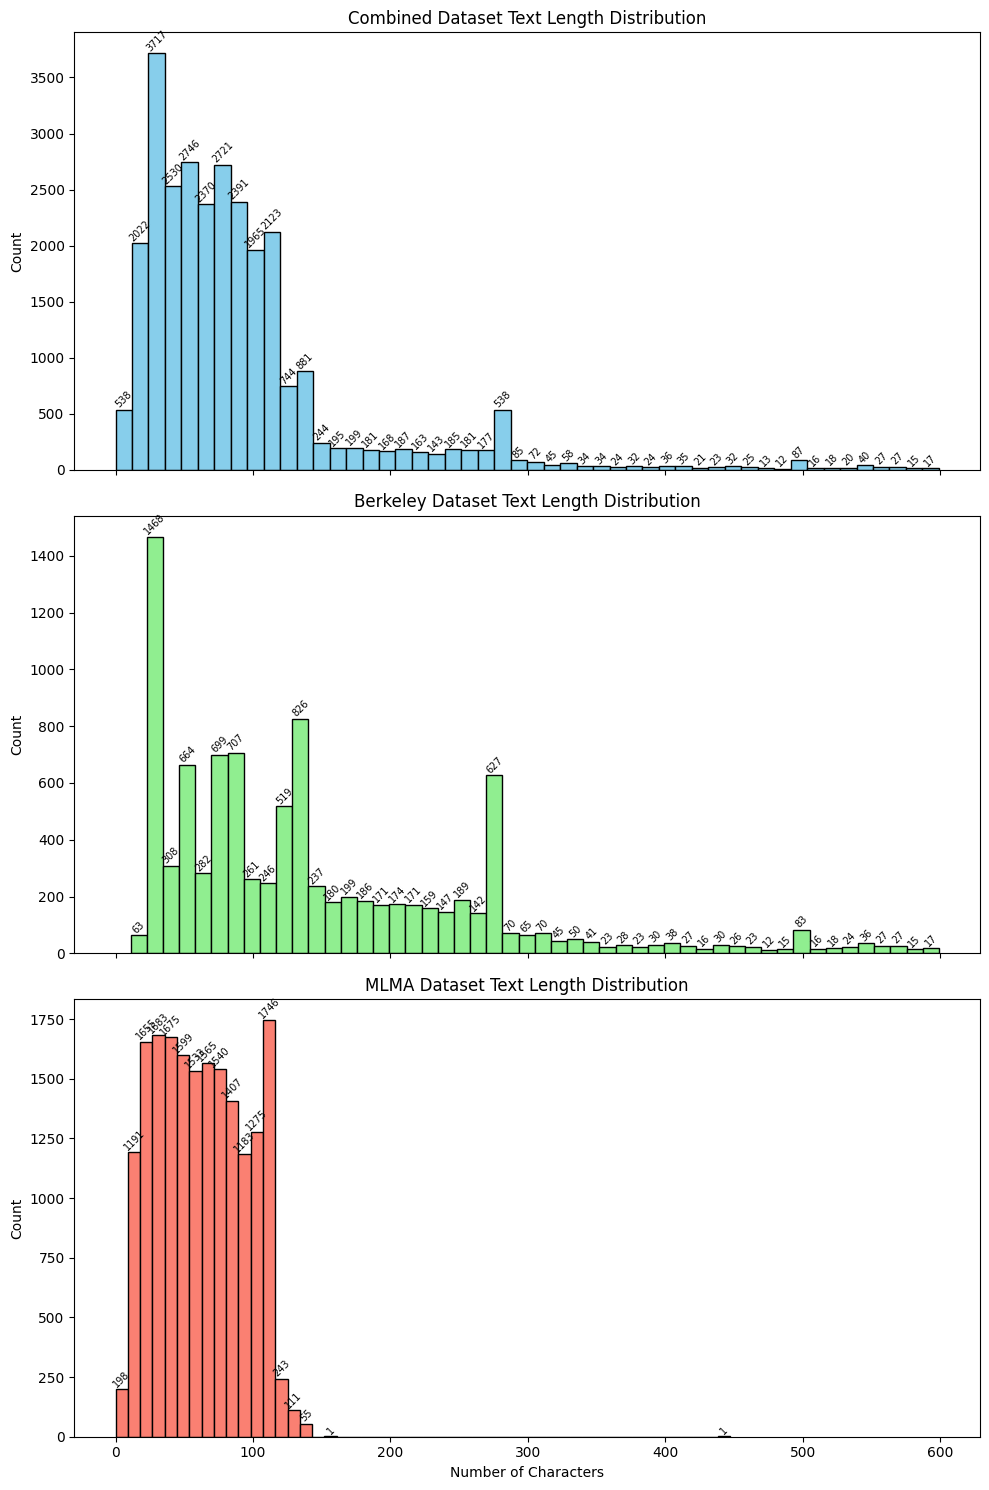

In [40]:
datasets = [
    ("Combined Dataset", combined_df),
    ("Berkeley Dataset", berkeley_df),
    ("MLMA Dataset", mlma_df)
]

fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

for ax, (title, df), color in zip(axes, datasets, ['skyblue', 'lightgreen', 'salmon']):
    df['text_length'] = df['text_cleaned'].astype(str).apply(len)
    counts, bins, patches = ax.hist(df['text_length'], bins=50, color=color, edgecolor='black')
    ax.set_title(f"{title} Text Length Distribution")
    ax.set_ylabel('Count')
    for count, bin_left, bin_right in zip(counts, bins[:-1], bins[1:]):
        if count > 0:
            ax.text((bin_left + bin_right) / 2, count, str(int(count)),
                    ha='center', va='bottom', fontsize=7, rotation=45)
axes[-1].set_xlabel('Number of Characters')
plt.tight_layout()
plt.show()

In [41]:
# Number English tweets with <= 140 characters in MLMA and Berkeley datasets
print(len(mlma_df[(mlma_df['text_length'] <= 150) & (mlma_df['language'] == 'english')]))
print(len(berkeley_df[(berkeley_df['text_length'] <= 150)]))

11293
6244


### DROP LONGER TEXTS

In [42]:
# So the model does not learn to classify based on text length
print(f"Before filtering out long texts: {combined_df.shape}")
combined_df = combined_df[combined_df['text_length'] <= 150]

print(f"After filtering out long texts: {combined_df.shape}")

Before filtering out long texts: (28181, 21)
After filtering out long texts: (24903, 21)


## Shuffle, Split, and Export Datasets

In [43]:
# Shuffle before converting to pandas
combined_df = Dataset.from_pandas(combined_df)
combined_df = combined_df.shuffle(seed=100)
combined_df = combined_df.to_pandas().reset_index(drop=True)

# Split: 80% train, 10% val, 10% test
train_df, temp_df = train_test_split(combined_df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train size: {train_df.shape}")
print(f"Validation size: {val_df.shape}")
print(f"Test size: {test_df.shape}")

# Filter wanted columns
cols_to_keep = [
    'text_cleaned', 'language', 'directness_label', 'target_label', 'group_label', 'hatespeech'
] + [col for col in combined_df.columns if col.startswith('sentiment_')]
train_df_export = train_df[cols_to_keep]
val_df_export = val_df[cols_to_keep]
test_df_export = test_df[cols_to_keep]

# Output to CSV
train_df_export.to_csv("../Data/train.csv", index=False)
val_df_export.to_csv("../Data/val.csv", index=False)
test_df_export.to_csv("../Data/test.csv", index=False)

train_df_export.head()

Train size: (19922, 22)
Validation size: (2490, 22)
Test size: (2491, 22)


,text_cleaned,language,directness_label,target_label,group_label,hatespeech,sentiment_anger,sentiment_confusion,sentiment_disgust,sentiment_fear,sentiment_indifference,sentiment_normal,sentiment_sadness,sentiment_shock
2112,qui connaissait ce militant de la cause animal...,french,1,4,8,1,0,0,0,0,0,0,0,1
17045,surtout les noirs et les arabes au pire ils au...,french,1,3,0,1,0,0,1,0,1,0,0,0
20274,Lailat al Miraj mubarak to all Muslims.. I'm w...,english,2,2,12,0,0,0,0,0,0,1,0,0
15776,dads twat look like him. break homes well prick.,english,1,4,13,1,1,0,1,0,0,0,0,0
18567,Navajo Census 2020 Complete Count Commission S...,english,2,2,12,0,0,0,0,0,0,1,0,0
